In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from pytorch_lightning import LightningModule, Trainer
import kornia as K
from sklearn.model_selection import train_test_split

import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import os
import glob

%matplotlib inline

In [2]:
list_train = glob.glob('TrainIJCNN2013/TrainIJCNN2013' + '/*')
list_train = [string.split('/')[-1] for string in list_train if '.ppm' in string]
len(list_train), list_train[0]

(600, '00316.ppm')

In [3]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    # x_min, y_min, w, h = bbox
    bbox = [int(i) for i in bbox]
    x_min, y_min, x_max, y_max = bbox
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(str(class_name), cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=str(class_name),
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name=None):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        if category_id_to_name:
            class_name = category_id_to_name[category_id]
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('TrainIJCNN2013/TrainIJCNN2013/gt.txt', sep=';', header=None)
data.rename(columns={0: "image", 5: "class"}, inplace=True)
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


<AxesSubplot:ylabel='Frequency'>

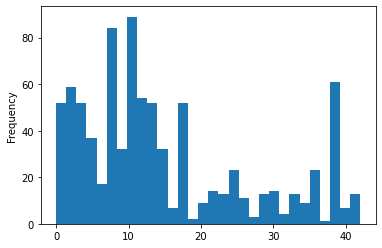

In [6]:
data['class'].plot.hist(bins=30)

In [7]:
data[data['image'] == '00001.ppm']

,image,1,2,3,4,class
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13


In [8]:
# data.drop(data[(data['class'] == 41) | (data['class'] == 42)].index, inplace=True)
# data.reset_index(drop=True, inplace=True)
# data

In [9]:
# data[data['class'] == 32].head() # 12, 14, 17, 41 ,42

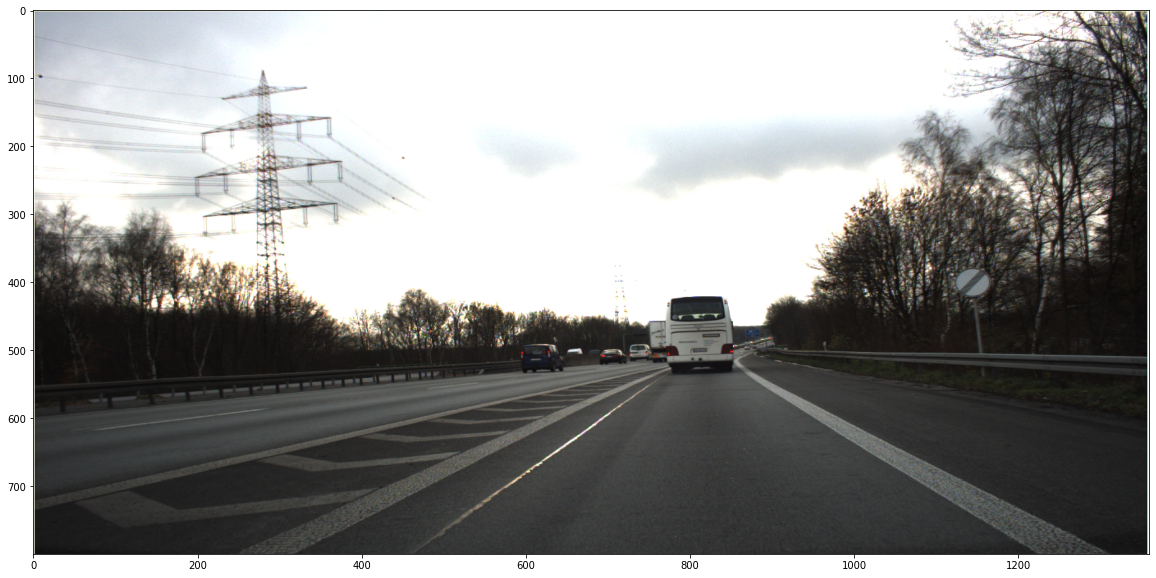

In [10]:
im = cv2.imread('TrainIJCNN2013/TrainIJCNN2013/00317.ppm')
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (20,10))
plt.imshow(im, aspect='auto')

In [11]:
def get_label(label):
    prohibitory = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]  # (circular, white ground with red border)
    mandatory = [33, 34, 35, 36, 37, 38, 39, 40]  # (circular, blue ground)
    danger = [11, 13, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]  # (triangular, white ground with red border)
    # rare = [12, 14, 17, 41 ,42] 

    if label in prohibitory:
        new_label = 1
    elif label in mandatory:
        new_label = 2
    elif label in danger:
        new_label = 3
    else:
        new_label = 4

    return new_label

In [12]:
data['class'] = data['class'].apply(get_label)

In [13]:
data.head()

,image,1,2,3,4,class
0,00000.ppm,774,411,815,446,3
1,00001.ppm,983,388,1024,432,2
2,00001.ppm,386,494,442,552,2
3,00001.ppm,973,335,1031,390,3
4,00002.ppm,892,476,1006,592,2


In [14]:
ser = data[data['image'] == '00001.ppm']

In [15]:
for index, row in ser.iterrows():
    print(index)
    print(row['image'])


1
00001.ppm
2
00001.ppm
3
00001.ppm


<AxesSubplot:ylabel='Frequency'>

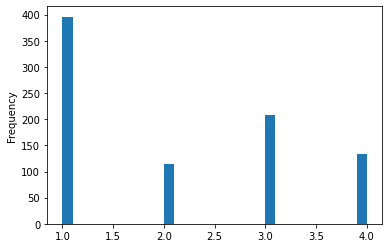

In [16]:
data['class'].plot.hist(bins=30)

In [17]:
stratify = data['class'].value_counts().values
stratify = stratify/stratify.sum()
stratify

array([0.46478873, 0.24413146, 0.157277  , 0.13380282])

In [18]:
train, val = train_test_split(data, test_size=0.2, stratify=data['class'])

In [19]:
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

In [20]:
train

,image,1,2,3,4,class
0,00515.ppm,257,361,333,435,1
1,00076.ppm,789,471,815,495,1
2,00166.ppm,814,382,848,416,1
3,00435.ppm,834,535,862,564,1
4,00386.ppm,555,561,580,586,1
...,...,...,...,...,...,...
676,00039.ppm,938,167,1022,251,4
677,00300.ppm,680,430,710,458,3
678,00391.ppm,198,508,247,558,4
679,00049.ppm,985,354,1028,397,4


In [21]:
'''
class Augmentation_train(nn.Module):
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.Resize((480, 640)),
    # K.augmentation.RandomHorizontalFlip(p=0.5),
    # K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(20, p=0.8),
    # K.augmentation.RandomElasticTransform(p=0.4),
    K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25, p=0.5),
    data_keys=['input', 'bbox'],
    same_on_batch=False,
    keepdim=True,
    )

    def __init__(self):
        super(Augmentation_train, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, bbox)

    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:
        # img = transform(img)
        x = self._augmentations(img, bbox)
        return x

class Augmentation_val(nn.Module):
    _augmentations = K.augmentation.AugmentationSequential(
    K.augmentation.Resize((480, 640)),
    data_keys=['input', 'bbox'],
    keepdim=True,
    )

    def __init__(self):
        super(Augmentation_val, self).__init__()

    @torch.no_grad()
    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:
        return self.augmentations(img, bbox)

    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:
        # img = transform(img)
        x = self._augmentations(img, bbox)
        return x

Aug_tr, Aug_val = Augmentation_train(), Augmentation_val()
'''

"\nclass Augmentation_train(nn.Module):\n    _augmentations = K.augmentation.AugmentationSequential(\n    K.augmentation.Resize((480, 640)),\n    # K.augmentation.RandomHorizontalFlip(p=0.5),\n    # K.augmentation.RandomVerticalFlip(p=0.5),\n    K.augmentation.RandomRotation(20, p=0.8),\n    # K.augmentation.RandomElasticTransform(p=0.4),\n    K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25, p=0.5),\n    data_keys=['input', 'bbox'],\n    same_on_batch=False,\n    keepdim=True,\n    )\n\n    def __init__(self):\n        super(Augmentation_train, self).__init__()\n\n    @torch.no_grad()\n    def forward(self, img: torch.Tensor, bbox: torch.Tensor) -> torch.Tensor:\n        return self.augmentations(img, bbox)\n\n    def augmentations(self, img: torch.Tensor, bbox: torch.Tensor) -> dict:\n        # img = transform(img)\n        x = self._augmentations(img, bbox)\n        return x\n\nclass Augmentation_val(nn.Module):\n    _augmentations = K.augmentation.AugmentationSequential(\n    K.au

In [22]:
transform = A.Compose([
    A.Resize(width=640, height=480),
    # A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

In [64]:
class DetectionDataset(Dataset):
    def __init__(self, data, root, transforms = None):
        self.data = data
        self.root = root
        self.transforms = transforms
        self.names = data['image'].unique()

    def __getitem__(self, idx):
        name = self.names[idx]
        df = self.data[self.data['image'] == name]
        img_path = os.path.join(self.root, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        bboxes = []
        labels = []
        # print(df)
        for index, row in df.iterrows():
            # print(row)
            bboxes.append([int(row[1]), int(row[2]), int(row[3]), int(row[4])])
            labels.append(row['class'])

        # boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=bboxes, category_ids=labels)
            img = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['category_ids']
        # target = {}
        # # target["bboxes"] = torch.as_tensor(bboxes, dtype=torch.int)
        # # target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        # target["bboxes"] = bboxes
        # target["labels"] = labels
        # return img, target
        return img, bboxes, labels

    def __len__(self):
        return len(self.names)

    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()
        # targets = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            # targets.append({'boxes' : b[1], 'labels' : b[2]})

        images = torch.stack(images, dim=0)

        return images, boxes, labels  # tensor (N, 3, 300, 300), 3 lists of N tensors each
        # return images, targets  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [65]:
train_set = DetectionDataset(train, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)
val_set = DetectionDataset(val, 'TrainIJCNN2013/TrainIJCNN2013', 
transform
)


In [66]:
im, boxes, labels = train_set[0]

In [67]:
im.max()

255

In [68]:
im.shape, boxes, labels

((480, 640, 3), [(120.94117647058823, 216.6, 156.70588235294116, 261.0)], [1])

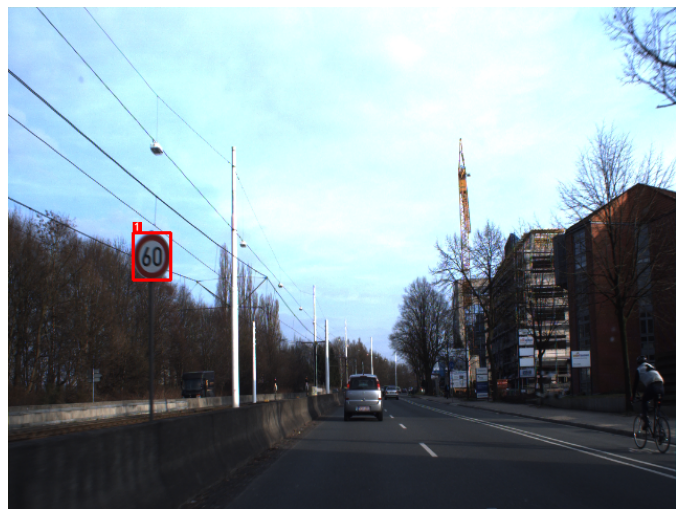

In [69]:
# visualize(im, target['bboxes'], target['labels'])
visualize(im, boxes, labels)

In [70]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [71]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [72]:
data_loader = torch.utils.data.DataLoader(
 train_set, batch_size=2, shuffle=True, num_workers=4, 
 )
val_loader = torch.utils.data.DataLoader(
 val_set, batch_size=2, shuffle=True, num_workers=4,
 )


In [73]:
# images,targets = next(iter(data_loader))
# images, bboxes, labels = next(iter(data_loader))
next(iter(data_loader))

[tensor([[[[255, 255, 255],
           [255, 255, 255],
           [255, 255, 255],
           ...,
           [255, 255, 255],
           [255, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [107, 166, 202],
           [115, 170, 213],
           ...,
           [213, 255, 255],
           [213, 255, 255],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [112, 170, 241],
           [111, 168, 254],
           ...,
           [218, 255, 255],
           [217, 255, 255],
           [255, 255, 255]],
 
          ...,
 
          [[255, 255, 255],
           [ 14,  16,  15],
           [ 16,  17,  23],
           ...,
           [ 50,  61,  77],
           [ 33,  61,  76],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [ 15,  18,  17],
           [ 16,  18,  23],
           ...,
           [ 51,  62,  77],
           [ 35,  63,  77],
           [255, 255, 255]],
 
          [[255, 255, 255],
           [ 15,  19

In [40]:
images[0], bboxes[0], labels[0]

(tensor([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [ 26,  22,   0],
          [ 38,  35,   0],
          ...,
          [179, 178, 147],
          [137, 168, 138],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [ 29,  22,  15],
          [ 19,  17,  16],
          ...,
          [185, 183, 186],
          [107, 132, 140],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [ 19,  19,  14],
          [ 20,  20,  20],
          ...,
          [ 17,  16,  17],
          [ 12,  16,  16],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [ 20,  19,  14],
          [ 19,  19,  21],
          ...,
          [ 19,  19,  20],
          [ 13,  17,  19],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [ 20,  19,  14],
          [ 20,  19,  20],
   

In [42]:
imges = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
model.train()
output = model(imges, {'boxes' : bboxes, 'labels' : labels})   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

TypeError: string indices must be integers

In [38]:
predictions

[{'boxes': tensor([[219.2818,   7.3605, 398.1508, 275.7732],
          [140.2519, 207.3492, 144.2080, 211.3917],
          [ 88.2682,   8.1540, 400.0000, 162.2480],
          [169.1596, 109.5636, 173.2784, 114.9783],
          [169.5105, 120.0007, 175.8296, 125.3795],
          [168.8111, 107.4339, 172.9142, 112.9711],
          [168.8278, 121.3530, 173.6985, 126.5963],
          [170.7575, 119.0855, 177.6416, 123.9014],
          [165.6716,  93.1886, 372.5268, 241.8611],
          [238.2707, 152.4580, 400.0000, 294.5307],
          [260.3242, 113.3094, 400.0000, 243.5939],
          [342.8900, 105.1718, 400.0000, 277.7253],
          [179.4280, 109.7118, 183.2331, 113.5505],
          [264.1791,  61.5384, 267.9516,  66.0814],
          [264.1764,  59.6367, 268.0128,  64.4434],
          [265.1284,  60.1239, 269.1933,  65.3182],
          [  0.0000, 114.0654, 303.6537, 269.9077],
          [140.5443, 208.8273, 144.3239, 212.9040],
          [204.5810, 184.3455, 208.4408, 188.9421],
   